## Multiple time-series models

!NOTE: this notebook uses an archived version of the library

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import pandas as pd
import numpy as np

import polars as pl
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso

In [2]:
__context__ = 'local'

import sys

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    libraryLocation = '..'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    

elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    libraryLocation = '/kaggle/input/'
    import enefit
    env = enefit.make_env()

iter_test = env.iter_test()
sys.path.append(libraryLocation)

## I want to try using multiple different baseline models of time dependency

This aims to address the fact that different types of units (eg. business vs resdential) seem to have different consumption profiles. It is a preliminary version of a more full (validatable) model.

In [3]:
from enefittools.data import format_dfs

from enefittools.archive.regression_features import make_date_process, make_time_features

def split_production_consumption(features, targets):
    """ splits the features and targets into production and consumption set
    """
    production_features = features.filter(
                                        pl.col('is_consumption') == 0
                                 ).drop('is_consumption')
    production_targets = targets.filter(
                                        pl.col('is_consumption') == 0
                               ).drop('is_consumption')

    consumption_features = features.filter(
                                        pl.col('is_consumption') == 1
                                  ).drop('is_consumption')
    consumption_targets = targets.filter(
                                        pl.col('is_consumption') == 1
                                ).drop('is_consumption')

    return (production_features, production_targets,
            consumption_features, consumption_targets)

train = pd.read_csv(trainDataLocation+'train.csv')
clients = pd.read_csv(trainDataLocation+'client.csv')

train, clients = format_dfs(target=train, client=clients)

dates = make_date_process(train)
features = make_time_features( train, clients, dates)

(production_features, production_targets,
     consumption_features, consumption_targets) = split_production_consumption(features, train)

In [4]:
from enefittools.archive.linear_models import TimeseriesFeatures

In [5]:
consumption_models = TimeseriesFeatures()
consumption_models.fit(consumption_features, consumption_targets)

production_models = TimeseriesFeatures()
production_models.fit(production_features, production_targets)


TimeseriesFeatures()

In [6]:
consumption_fits = consumption_models.transform(consumption_features)
production_fits = production_models.transform(production_features)

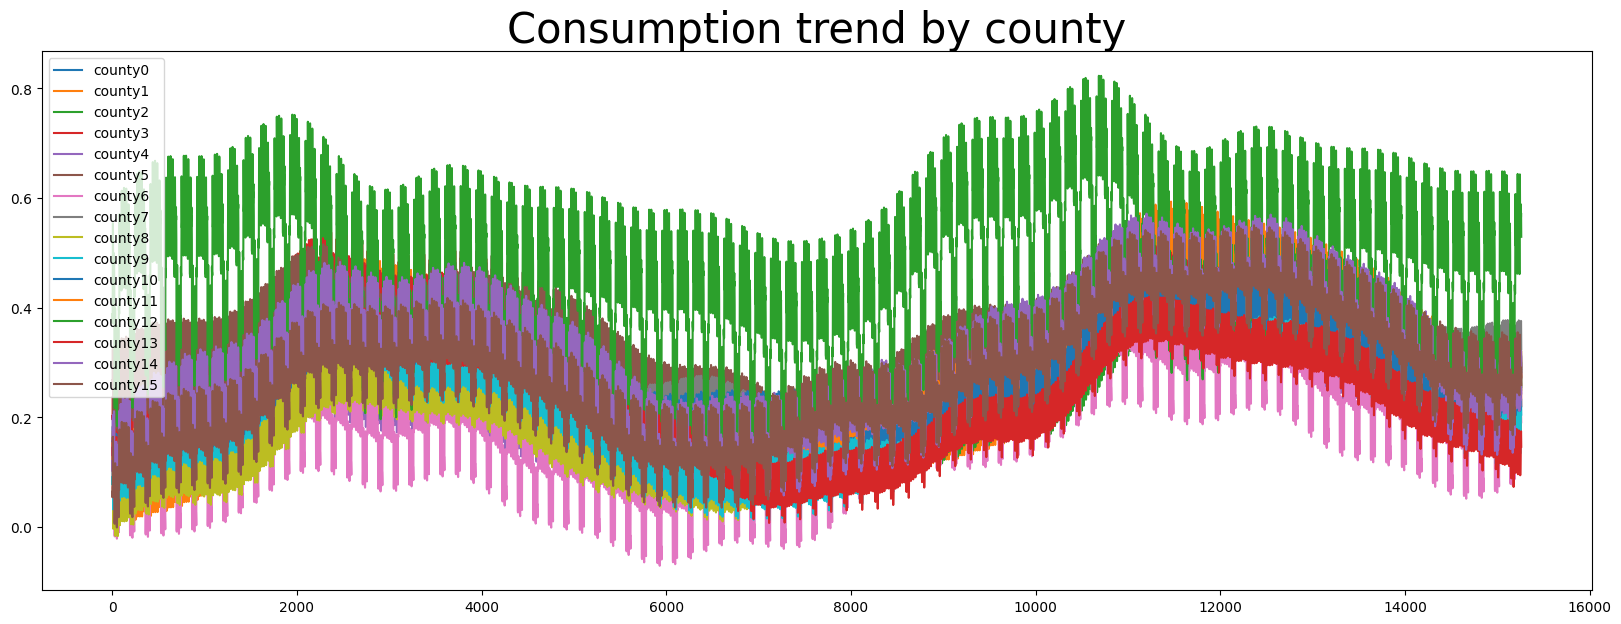

In [7]:
figsize(20,7)
consumption_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['county'+str(i) for i in range(16)]].to_pandas().plot()
_=plt.title('Consumption trend by county', fontsize=30)

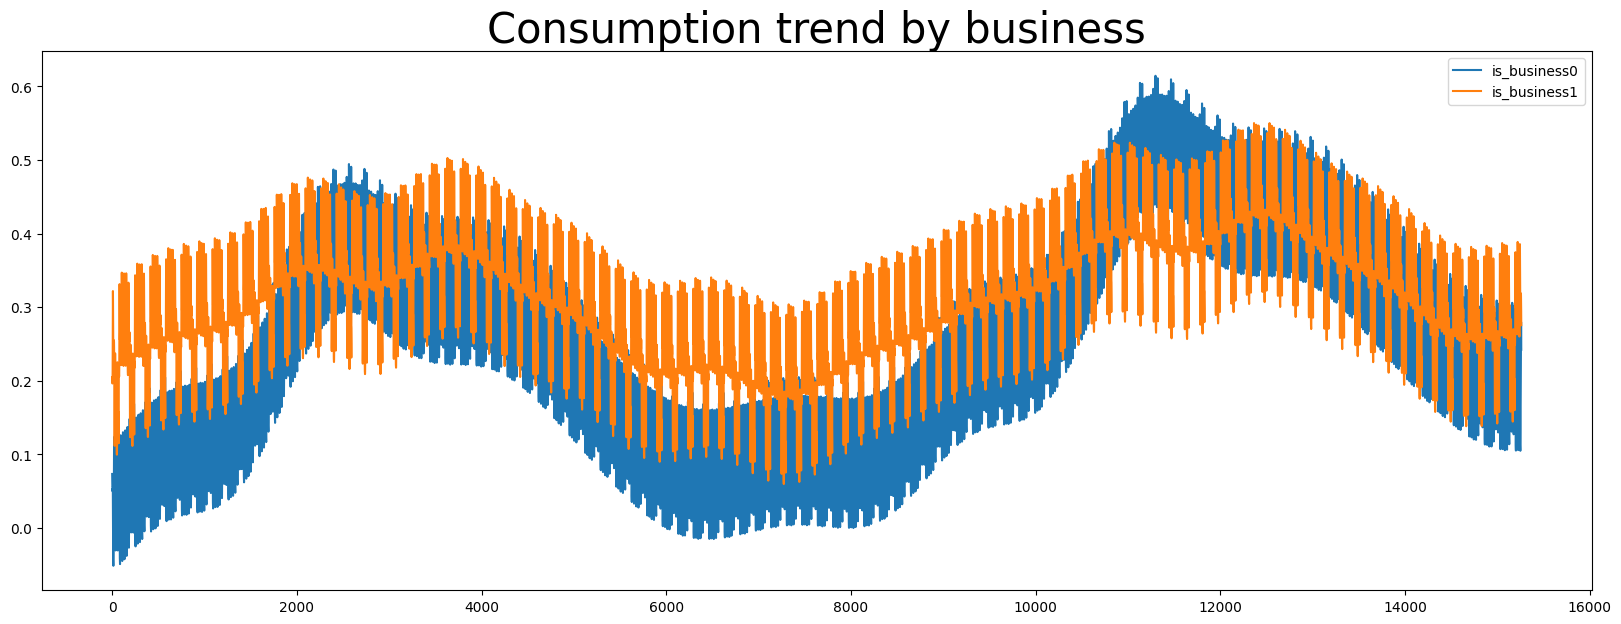

In [8]:
figsize(20,7)
consumption_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['is_business'+str(i) for i in range(2)]].to_pandas().plot()
_=plt.title('Consumption trend by business', fontsize=30)

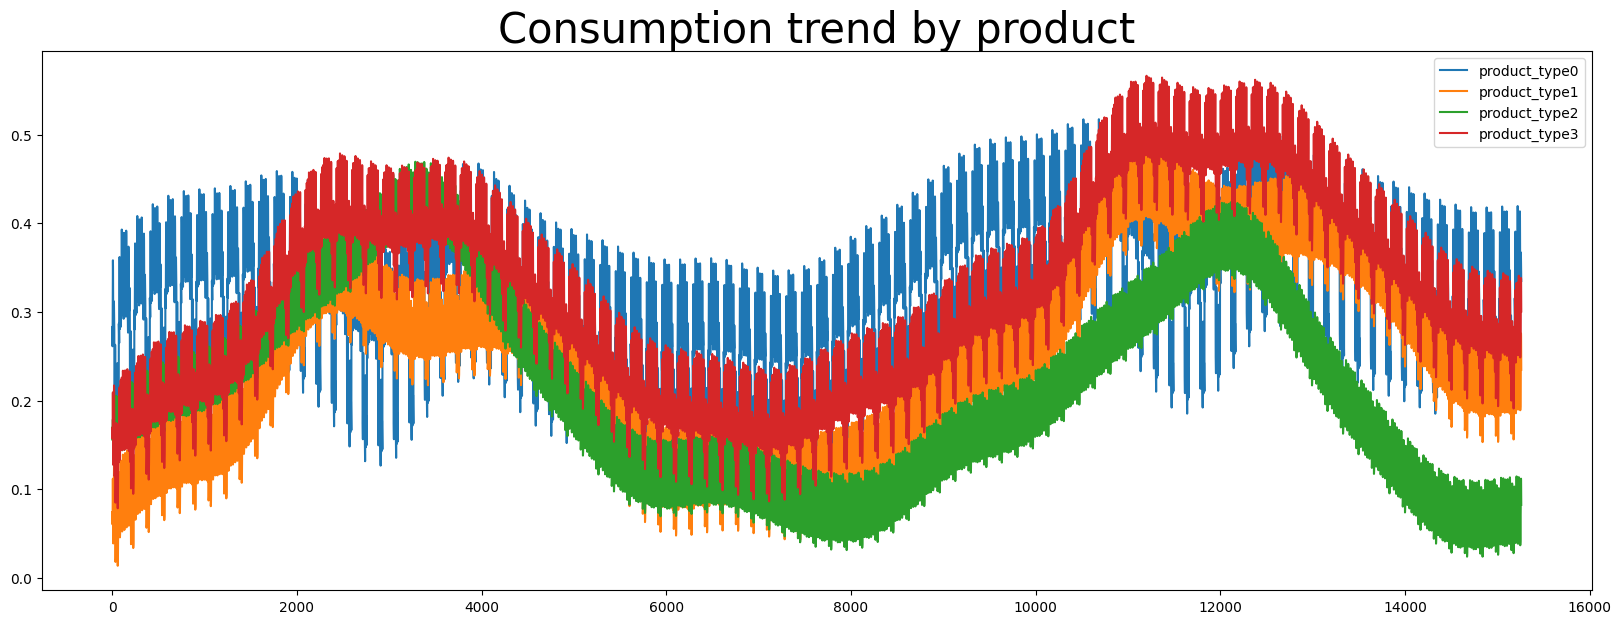

In [9]:
figsize(20,7)
consumption_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['product_type'+str(i) for i in range(4)]].to_pandas().plot()
_=plt.title('Consumption trend by product', fontsize=30)

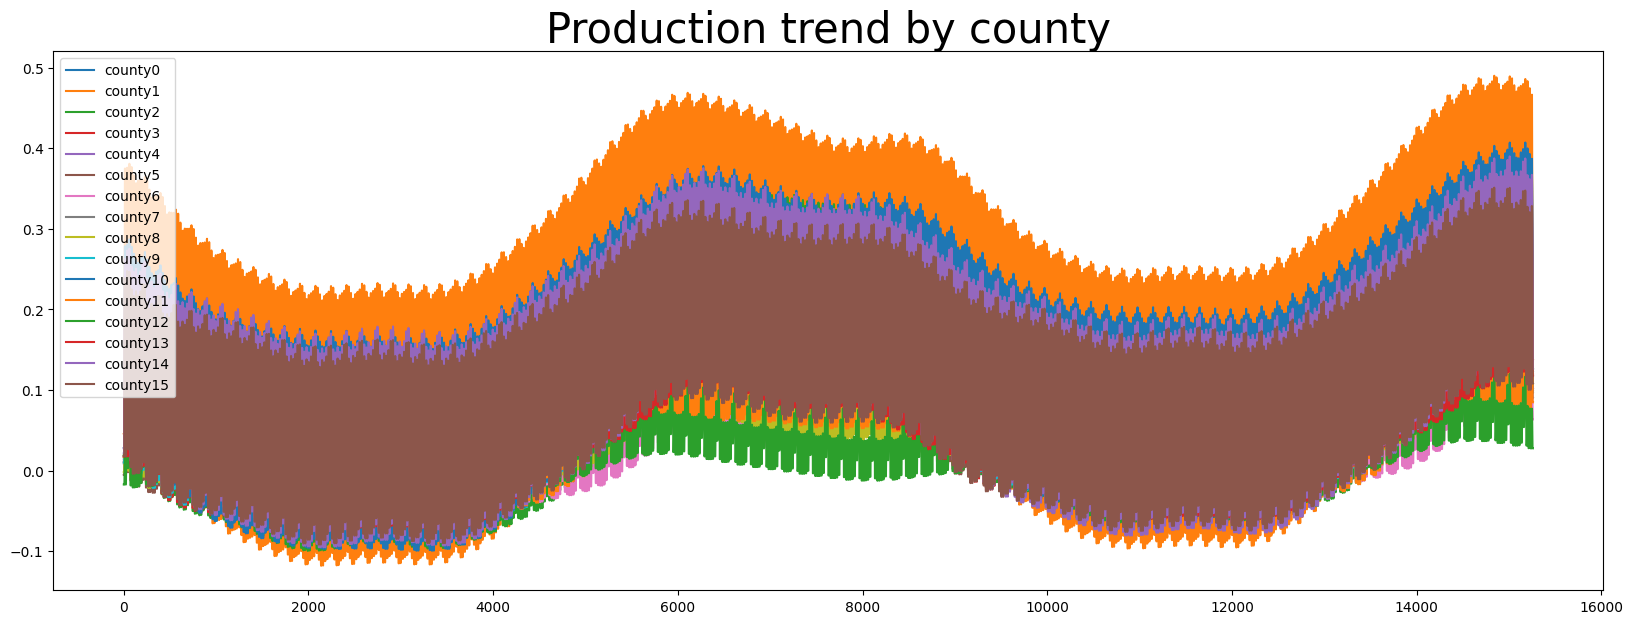

In [10]:
figsize(20,7)
production_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['county'+str(i) for i in range(16)]].to_pandas().plot()
_=plt.title('Production trend by county', fontsize=30)

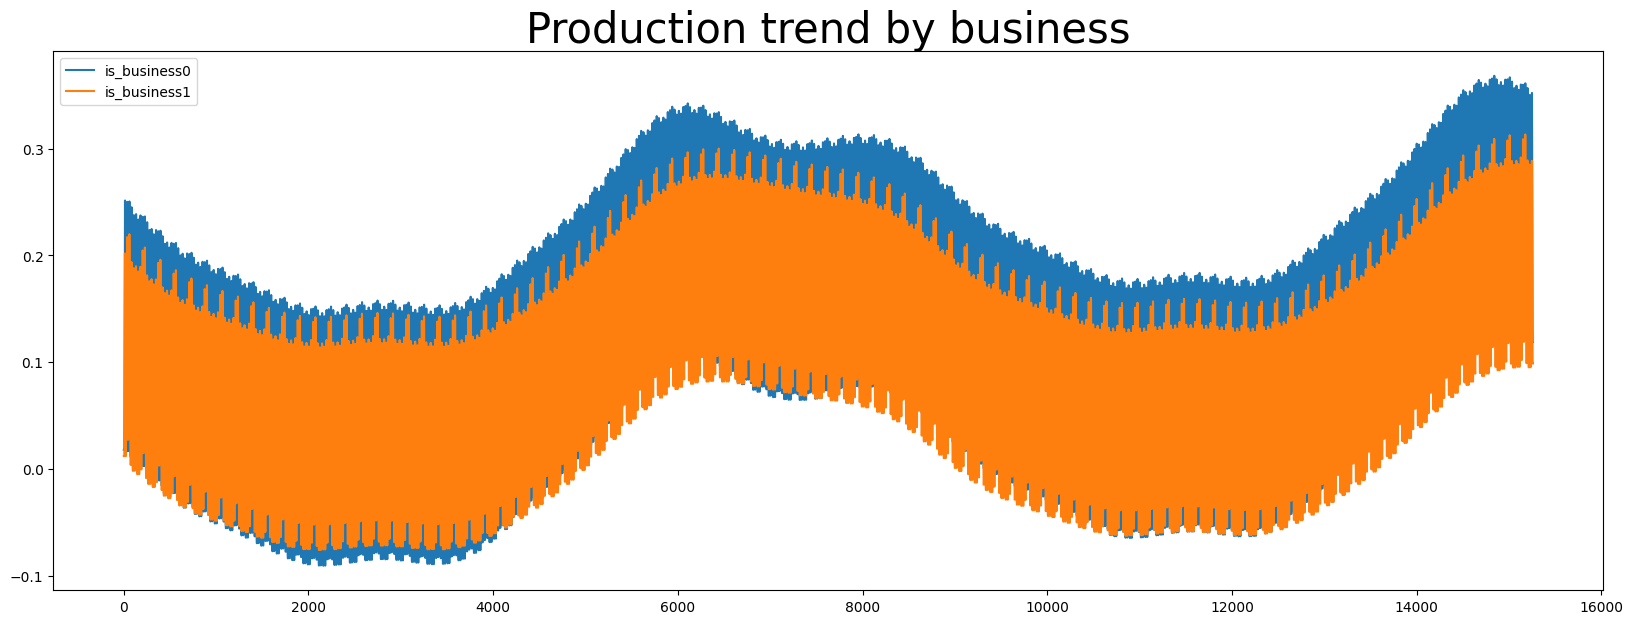

In [11]:
figsize(20,7)
production_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['is_business'+str(i) for i in range(2)]].to_pandas().plot()
_=plt.title('Production trend by business', fontsize=30)

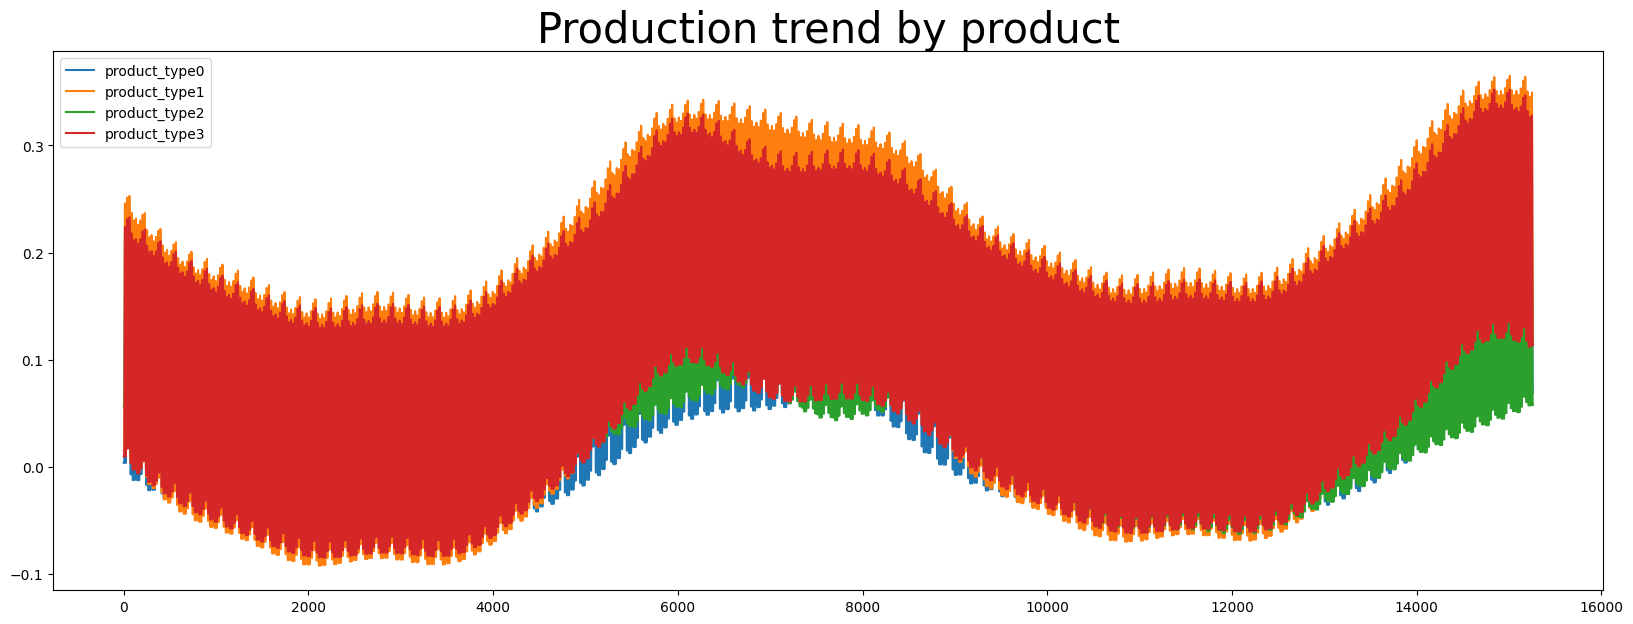

In [12]:
figsize(20,7)
production_fits.filter(pl.col('prediction_unit_id') == 10
                       )[['product_type'+str(i) for i in range(4)]].to_pandas().plot()
_=plt.title('Production trend by product', fontsize=30)

In [13]:
from sklearn.pipeline import Pipeline
from enefittools.archive.linear_models import ParallelLinearModels


consumption_pipeline = Pipeline([('time basis', TimeseriesFeatures()), 
                                 ('linear', ParallelLinearModels())])

production_pipeline = Pipeline([('time basis', TimeseriesFeatures()), 
                                 ('linear', ParallelLinearModels())])

In [14]:
consumption_pipeline.fit(consumption_features, consumption_targets)

Pipeline(steps=[('time basis', TimeseriesFeatures()),
                ('linear', ParallelLinearModels())])

In [15]:
production_pipeline.fit(production_features, production_targets)

Pipeline(steps=[('time basis', TimeseriesFeatures()),
                ('linear', ParallelLinearModels())])

In [16]:
for (test, revealed_targets, client, weatherHistorical, weatherForecast,
    electricityPrices, gasPrices, sample_prediction) in iter_test:

    test, client = format_dfs(target=test, client=client)
    features = make_time_features(test, client, dates)

    productionFeatures = features.filter(pl.col('is_consumption') == 0).drop(['is_consumption', 'currently_scored'])
    consumptionFeatures = features.filter(pl.col('is_consumption') == 1).drop(['is_consumption', 'currently_scored'])
    
    productionPredictions = production_pipeline.predict(productionFeatures)
    consumptionPredictions = consumption_pipeline.predict(consumptionFeatures)

    fullPredictions = pl.concat([productionPredictions, consumptionPredictions], how='vertical').to_pandas()
    prediction = sample_prediction.merge(fullPredictions[['row_id', 'target']], 
                                         on='row_id', how='left', suffixes=['_old', '']
                                        ).drop(columns='target_old').fillna(0.0)
    env.predict(prediction)